<a href="https://colab.research.google.com/github/GarimaChopra/AML/blob/main/Project7_FacialRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The facesDB dataset contains 400 greyscale BMP images, where each image is 48x48 pixels and has 3 channels. There are 40 subjects, and 10 images per subject arranged in folders S1-S40.

In [236]:
#import statements# Using Pandas for importing data from file 
import pandas as pd

# Import matplotlib and seaborn libraries to visualize the data
import matplotlib.pyplot as plt 
import seaborn as sns

# Using numpy for to operate on multidimentional arrays.
import numpy as np
from numpy import mean
from numpy import std

# Using zipfile and os to extract images 
import os

# for random number generator
import random

# for viewing images
import cv2

#Other import statements
from sklearn.model_selection import KFold
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.optimizers import SGD
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

**1) Problem Statement :** Upload the images into Colab

In [188]:
# downloading files from url
!wget 'https://raw.githubusercontent.com/GarimaChopra/AML/main/facesDB.zip'


--2021-05-18 02:35:08--  https://raw.githubusercontent.com/GarimaChopra/AML/main/facesDB.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1374115 (1.3M) [application/zip]
Saving to: ‘facesDB.zip.7’

facesDB.zip.7       100%[===================>]   1.31M  --.-KB/s    in 0.01s   

2021-05-18 02:35:09 (108 MB/s) - ‘facesDB.zip.7’ saved [1374115/1374115]



In [189]:
#Extracting files from zip folder
!unzip facesDB.zip

Archive:  facesDB.zip
replace facesDB/S1/1.BMP? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: facesDB/S1/1.BMP        
  inflating: facesDB/S1/10.BMP       
  inflating: facesDB/S1/2.BMP        
  inflating: facesDB/S1/3.BMP        
  inflating: facesDB/S1/4.BMP        
  inflating: facesDB/S1/5.BMP        
  inflating: facesDB/S1/6.BMP        
  inflating: facesDB/S1/7.BMP        
  inflating: facesDB/S1/8.BMP        
  inflating: facesDB/S1/9.BMP        
  inflating: facesDB/S1/Thumbs.db    
  inflating: facesDB/S10/1.BMP       
  inflating: facesDB/S10/10.BMP      
  inflating: facesDB/S10/2.BMP       
  inflating: facesDB/S10/3.BMP       
  inflating: facesDB/S10/4.BMP       
  inflating: facesDB/S10/5.BMP       
  inflating: facesDB/S10/6.BMP       
  inflating: facesDB/S10/7.BMP       
  inflating: facesDB/S10/8.BMP       
  inflating: facesDB/S10/9.BMP       
  inflating: facesDB/S10/Thumbs.db   
  inflating: facesDB/S11/1.BMP       
  inflating: facesDB/S11/10.BMP      


The Dataset contains 40 target classes and 400 samples (10 for each class ). 
A direct split of train/test data will result in a biased dataset, leaving few classes completely out of training/test data, Hence creating function to take 2 images randomly from each class for test dataset (resulting in an 80% training and 20% test data distribution)

In [190]:
trainX = list()
trainY = list()
testX = list()
testY= list()

for i in range(1, 41):
  rands = random.sample(range(1, 11), 2) # Generates 2 random numbers for image indices
  for j in range(1, 11):
    img = cv2.imread("facesDB/S{0}/{1}.BMP".format(str(i), str(j)))
    if j in rands:
      testX.append(img)
      testY.append(i - 1)
    else:
      trainX.append(img)
      trainY.append(i - 1)
trainX = np.asarray(trainX)
trainY = np.asarray(trainY)
testX = np.asarray(testX)
testY = np.asarray(testY)

In [191]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(320, 48, 48, 3)
(320,)
(80, 48, 48, 3)
(80,)


**2) Problem Statement:** Process the images as necessary and form training and testing sets. Display a few of the images to show the images were correctly read. 

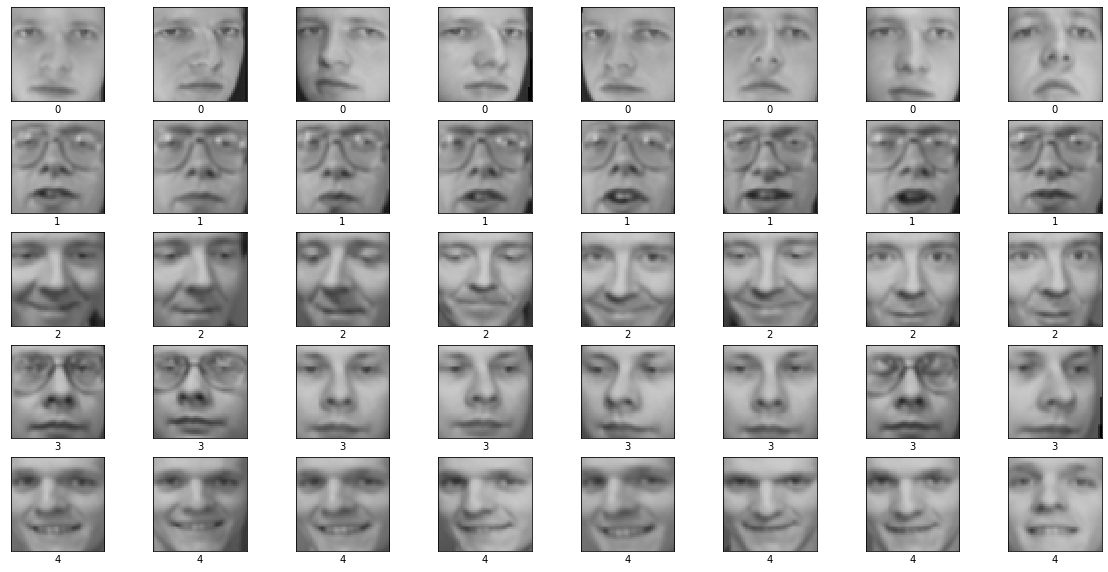

In [192]:
#Display dataset for 5 training classes
plt.figure(figsize=(20, 10))
for i in range( 40 ):
    plt.subplot( 5, 8, i+1 )
    plt.xticks([])
    plt.yticks([])
    plt.imshow(trainX[i], cmap=plt.cm.gray, interpolation='nearest')
    plt.xlabel(trainY[i])
plt.show()

In [193]:
# one-hot encode target values
trainY = to_categorical(trainY)
testY = to_categorical(testY)

print(trainY.shape)
print(testY .shape)

(320, 40)
(80, 40)


we need to normalize the training data to ensure input pixels have a  similar data distribution. This makes convergence faster while training the model

In [194]:
trainX = trainX.astype( 'float32' )/255
testX = testX.astype( 'float32' )/255


**3) Problem Statement:** Build a convolutional neural network model.

In [195]:
#The CNN model has two main aspects: the feature extraction front end comprised of 
# convolutional and pooling layers, and the classifier backend that will make a prediction.

def create_compile_model_1():
  model = Sequential([
    Conv2D(32, (3,3), activation="relu", padding="same", input_shape=trainX[0].shape),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(64, activation="relu"),
    Dropout(0.5),
    Dense(40, activation="softmax")
    ])
  opt = SGD(lr=0.01, momentum=0.9)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model


**Problem Statement:** 

4)Evaluate the model, and display the model information as the network is being trained (use the verbose mode)

5) Plot the model's accuracy/loss values as well as the validated accuracy/loss values during training

In [196]:
model1 =create_compile_model_1()

In [197]:
history = model1.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY),verbose=True)


Epoch 1/10
10/10 [==============================] - 11s 1s/step - loss: 3.6927 - accuracy: 0.0381 - val_loss: 3.6887 - val_accuracy: 0.0250
Epoch 2/10
10/10 [==============================] - 10s 987ms/step - loss: 3.6932 - accuracy: 0.0083 - val_loss: 3.6881 - val_accuracy: 0.0250
Epoch 3/10
10/10 [==============================] - 10s 986ms/step - loss: 3.6879 - accuracy: 0.0279 - val_loss: 3.6880 - val_accuracy: 0.0250
Epoch 4/10
10/10 [==============================] - 10s 990ms/step - loss: 3.6929 - accuracy: 0.0106 - val_loss: 3.6884 - val_accuracy: 0.0250
Epoch 5/10
10/10 [==============================] - 10s 982ms/step - loss: 3.6861 - accuracy: 0.0631 - val_loss: 3.6885 - val_accuracy: 0.0250
Epoch 6/10
10/10 [==============================] - 10s 986ms/step - loss: 3.6881 - accuracy: 0.0253 - val_loss: 3.6884 - val_accuracy: 0.0250
Epoch 7/10
10/10 [==============================] - 10s 979ms/step - loss: 3.6903 - accuracy: 0.0293 - val_loss: 3.6884 - val_accuracy: 0.0250
Ep

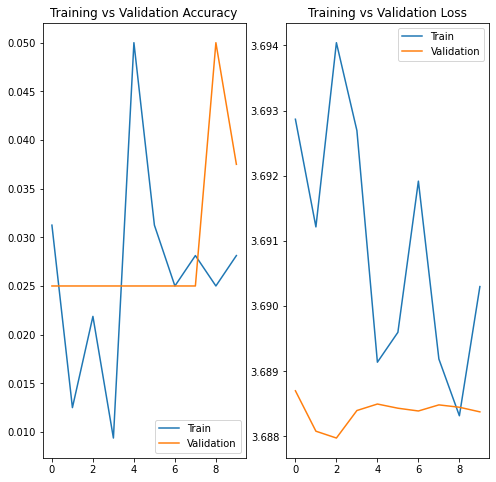

In [198]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(accuracy, label='Train')
plt.plot(val_accuracy, label='Validation')
plt.legend(loc='lower right')
plt.title('Training vs Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Train')
plt.plot(val_loss, label='Validation')
plt.legend(loc='upper right')
plt.title('Training vs Validation Loss')
plt.show()


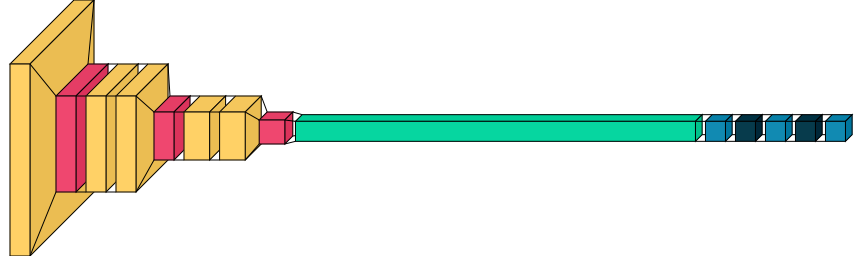

In [199]:
#%pip install visualkeras
import visualkeras

# Draw model1's architecture

#visualkeras.layered_view(model1, to_file='output.png') # write to disk
#visualkeras.layered_view(model1, to_file='output.png').show() # write and show

visualkeras.layered_view(model1)

In [200]:
# Evaluate the model using k-fold cross-validation

def evaluate_model(model, dataX, dataY, n_folds):

	scores, histories = list(), list()
 
	# prepare cross validation
	kfold = KFold(n_folds, shuffle=True, random_state=1)
 
	# enumerate splits
	for train_ix, test_ix in kfold.split(dataX):
  
		# select rows for train and test
		trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]

		# fit model
		history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
  
		# evaluate model
		_, acc = model.evaluate(testX, testY, verbose=0)
		print('CV Fold accuracy:  %.3f' % (acc * 100.0))
  
		# stores scores
		scores.append(acc)
		histories.append(history)
  
	return scores, histories


In [201]:
# Plot learning curves

def summarize_learning(histories):

  for i in range(len(histories)):
		
    # plot loss
    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(histories[i].history['loss'], color='blue', label='train')
    plt.plot(histories[i].history['val_loss'], color='orange', label='test')
		
    # plot accuracy
    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(histories[i].history['accuracy'], color='red', label='train')
    plt.plot(histories[i].history['val_accuracy'], color='green', label='test')
  
    plt.show()

In [202]:
# Summarize model performance

def summarize_performance(scores):

	# print summary
	print('Model Accuracy: mean=%.3f std=%.3f, folds=%d' % (np.mean(scores)*100, np.std(scores)*100, len(scores)))
 


In [203]:
# The main driver for evaluating the model

def process(model, num_folds):
	# evaluate the model using CV
	scores, histories = evaluate_model(model, trainX, trainY, num_folds)
 
	# learning curves
	summarize_learning(histories)
 
	# summarize estimated performance
	summarize_performance(scores)

CV Fold accuracy:  0.000
CV Fold accuracy:  1.250
CV Fold accuracy:  0.000
CV Fold accuracy:  1.250


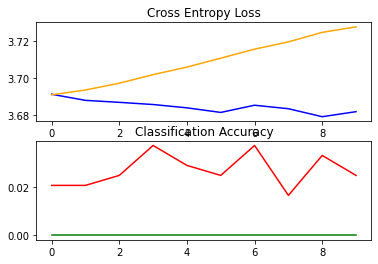

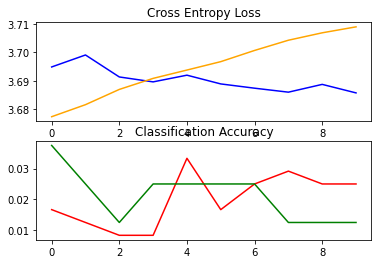

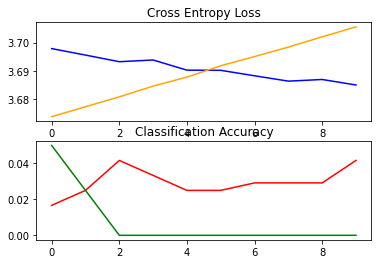

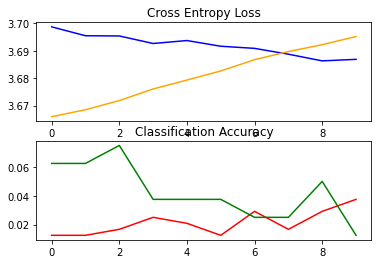

Model Accuracy: mean=0.625 std=0.625, folds=4


In [204]:

from keras.models import save_model, load_model

# Experiment with CNN architectures

num_folds = 4

# evaluate the model
process(model1, num_folds)

# save the model
model1.save('model1.h5')

The cross validation accuracy for the model is low. 

**6) ProblemStatement:** Run several different experiments (use GPU runtime) with different # convolution/max-pooling layers, # hidden layers, # nodes / hidden layer, dropout rates for the backend fully-connected dense layers, batch size, optimizer method, etc. Record the obtained accuracy results for each experiment, and graph the results of all the experiments in one plot.

In [207]:
#Convolution Layers

def create_compile_model_2():
  model = Sequential([
    Conv2D(32, (3,3), activation="relu", padding="same", input_shape=trainX[0].shape),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(64, activation="relu"),
    Dropout(0.5),
    Dense(40, activation="softmax")
    ])
  opt = SGD(lr=0.01, momentum=0.9)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [210]:
 #Dense Layer 
def create_compile_model_3():
  model = Sequential([
    Conv2D(32, (3,3), activation="relu", padding="same", input_shape=trainX[0].shape),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation="relu"),
    Dropout(0.5),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(64, activation="relu"),
    Dropout(0.5),
    Dense(40, activation="softmax")
    ])
  opt = SGD(lr=0.01, momentum=0.9)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [218]:
#Dropout rate

def create_compile_model_4():
  model = Sequential([
    Conv2D(32, (3,3), activation="relu", padding="same", input_shape=trainX[0].shape),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.8),
    Dense(64, activation="relu"),
    Dropout(0.8),
    Dense(40, activation="softmax")
    ])
  opt = SGD(lr=0.01, momentum=0.9)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [220]:
#optimizer

def create_compile_model_5():
  model = Sequential([
    Conv2D(32, (3,3), activation="relu", padding="same", input_shape=trainX[0].shape),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.8),
    Dense(64, activation="relu"),
    Dropout(0.8),
    Dense(40, activation="softmax")
    ])
  opt = SGD(lr=0.01, momentum=0.9)
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [221]:
model2 =create_compile_model_2()
model3 =create_compile_model_3()
model4 =create_compile_model_4()
model5 =create_compile_model_5()

In [222]:
history2 = model2.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY),verbose=0)
history3 = model3.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY),verbose=0)
history4 = model4.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY),verbose=0)
history5 = model5.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY),verbose=0)

Text(0.5, 1.0, 'Accuracy')

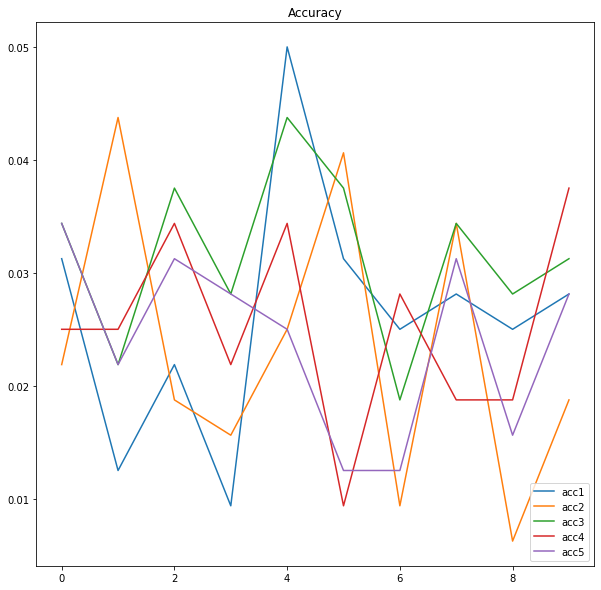

In [234]:
accuracy1 = history.history['accuracy']
accuracy2 = history2.history['accuracy']
accuracy3 = history3.history['accuracy']
accuracy4 = history4.history['accuracy']
accuracy5 = history5.history['accuracy']

plt.figure(figsize=(10, 10))
plt.plot(accuracy1, label='acc1')
plt.plot(accuracy2, label='acc2')
plt.plot(accuracy3, label='acc3')
plt.plot(accuracy4, label='acc4')
plt.plot(accuracy5, label='acc5')
plt.legend(loc='lower right')
plt.title('Accuracy')


In [232]:
summarize_performance(history.history['accuracy'])
summarize_performance(history2.history['accuracy'])
summarize_performance(history3.history['accuracy'])
summarize_performance(history4.history['accuracy'])
summarize_performance(history5.history['accuracy'])

Model Accuracy: mean=2.625 std=1.057, folds=10
Model Accuracy: mean=2.344 std=1.196, folds=10
Model Accuracy: mean=3.156 std=0.719, folds=10
Model Accuracy: mean=2.531 std=0.820, folds=10
Model Accuracy: mean=2.406 std=0.766, folds=10


Third model with more dense layer offers better accuracy.

In [238]:
testY=np.argmax(testY, axis=1)


[Text(159.0, 0.5, 'Actual'), Text(0.5, 69.0, 'Predicted')]

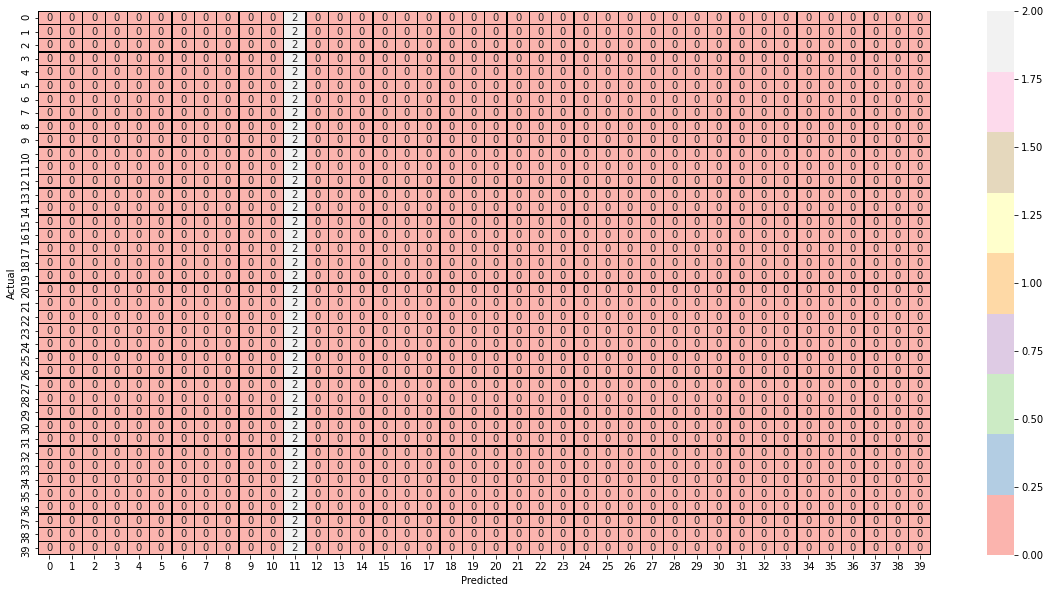

In [245]:
predY = np.argmax(model3.predict(testX), axis = 1)
cm = confusion_matrix(testY, predY)
plt.figure(figsize=(20,10))
heatmap = sns.heatmap(cm, cmap='Pastel1', annot=True, vmax=2, vmin=0, linewidths=.3, linecolor='black')
heatmap.set(xlabel="Predicted", ylabel = "Actual")

**Summary**

A CNN was created for the facial recognition dataset